In [1]:
import torch
import esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

/Users/arezoobybordi/miniforge3/envs/ninen/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

#### **Run after**

In [2]:
import pandas as pd
#pd.DataFrame(terra_data, index= v1['ids']). to_csv("id_added_teratoxin_snekmer.csv")

In [70]:
train_df = pd.read_csv("All_Toxins_v4.csv")

In [4]:
# place needs to be changed
terra_data = train_df

In [44]:
np.unique(train_df['Framework Confirmation'])

array(['1', '11', '12', '13', '14', '15', '16', '19', '22', '33',
       '6 and 7', '8', '9', 'novel'], dtype=object)

In [5]:
train_data = [(tuple(list(x))[1], tuple(list(x))[0])  for x in list(train_df[['Mature','ToxinName']].values)]

In [6]:
dummy_train = train_data

In [7]:
tr_batch_labels, tr_batch_strs, tr_batch_tokens = batch_converter(dummy_train)
tr_batch_lens = (tr_batch_tokens != alphabet.padding_idx).sum(1)


In [8]:
# Extract per-residue representations (on CPU)
with torch.no_grad():
    tr_results = model(tr_batch_tokens, repr_layers=[33], return_contacts=False)

In [9]:
tr_token_representations = tr_results["representations"][33]

In [10]:
# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
tr_sequence_representations = []
for i, tokens_len in enumerate(tr_batch_lens):
    tr_sequence_representations.append(tr_token_representations[i, 1 : tokens_len - 1].mean(0))


In [11]:
x = [tensor.numpy() for tensor in tr_sequence_representations]

In [12]:
import numpy as np

In [15]:
np.shape(x)

(1158, 1280)

In [13]:
terra_data = x

In [20]:
type(terra_data)

list

In [14]:
terra_data = np.array(terra_data)

#### **PCA:  95% variance explained.**

In [19]:
import numpy as np
from sklearn.decomposition import PCA


# Perform PCA for different numbers of components
n_components = range(1, terra_data.shape[0] + 1)
variance_explained = []
#total_variance = np.sum(np.var(reshaped_data, axis=0))

for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(terra_data)
    variance_explained.append(np.sum(pca.explained_variance_ratio_))

    # Check if 95% of total variance explained
    if variance_explained[-1] >= 0.95:
        print(f"Number of components needed to explain 95% variance: {n}")
        break

# Print the variance explained for each number of components
for i, var in enumerate(variance_explained):
    print(f"Components: {i+1}, Variance explained: {var:.4f}")

Number of components needed to explain 95% variance: 64
Components: 1, Variance explained: 0.3564
Components: 2, Variance explained: 0.4595
Components: 3, Variance explained: 0.5294
Components: 4, Variance explained: 0.5717
Components: 5, Variance explained: 0.6039
Components: 6, Variance explained: 0.6324
Components: 7, Variance explained: 0.6582
Components: 8, Variance explained: 0.6812
Components: 9, Variance explained: 0.7021
Components: 10, Variance explained: 0.7205
Components: 11, Variance explained: 0.7372
Components: 12, Variance explained: 0.7511
Components: 13, Variance explained: 0.7641
Components: 14, Variance explained: 0.7763
Components: 15, Variance explained: 0.7877
Components: 16, Variance explained: 0.7982
Components: 17, Variance explained: 0.8074
Components: 18, Variance explained: 0.8161
Components: 19, Variance explained: 0.8240
Components: 20, Variance explained: 0.8316
Components: 21, Variance explained: 0.8383
Components: 22, Variance explained: 0.8447
Compone

##### **Kmeans: Continue with components giving 95% explained variance, i.e. 64 PCs**

In [49]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
#transformed_pca_data = pca.fit_transform(terra_data)

In [46]:
pca.fit(terra_data)

PCA(n_components=64)

In [50]:
transformed_pca_data = pca.fit_transform(terra_data)

### KMeans with number of clusters 13

In [21]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=13, random_state=42).fit(transformed_pca_data)

In [43]:
predicted = kmeans.predict(transformed_pca_data)

In [60]:
cystines = list(train_df['Framework Confirmation'])

In [62]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Create a DataFrame with the data
df = pd.DataFrame({'Predicted': predicted, 'Cystines': cystines})

In [64]:
# Create a contingency table
contingency_table = pd.crosstab(df['Predicted'], df['Cystines'])

In [65]:
# Display the contingency table
print("Contingency Table:")
print(contingency_table)

Contingency Table:
Cystines    1  11  12  13  14  15  16  19  22  33  6 and 7    8   9  novel
Predicted                                                                 
0           0   0   0   0   2   0   0   0   0   0        0    0  19      2
1           0   0   0   0   0   0   0   0   2   1        1   72   4     18
2           0   0   0   0   0   0   0   0   1  12        0    3  25      4
3           0   0   0   0   2  36   0   0   1   0      101    0  29      5
4          10   0   3   9   0   0   0   0  28   0       20    5  47     15
5           0   0   0   0   0   0   0   0   1   0        0    9  24      9
6           0   0   0   0   0   0   0   0  55   0        1    0   3     12
7           0   1   0   0   3   0   0   0  13   0        0    0   1      6
8           0   0   0   0   0   0   0   0   0   0        0    0   0     10
9           0   1   0   0   5   0   1   0  34   0        1    2  14     18
10          9  21   4   5   4   1   1   0   4   0       95    0  50      6
11    

In [67]:
import matplotlib.pyplot as plt

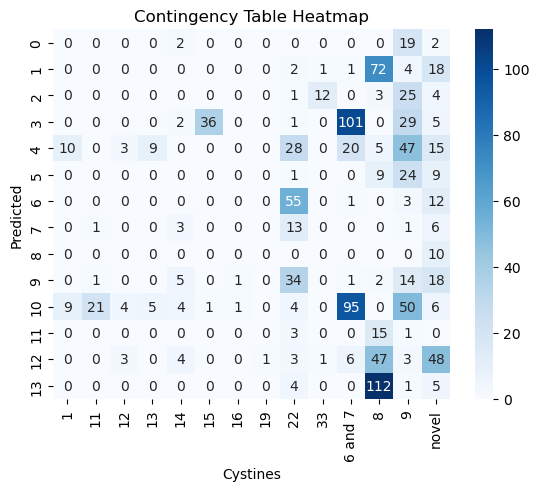

In [68]:
# Create a heatmap using Seaborn
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title('Contingency Table Heatmap PCA')
plt.show()


In [71]:
train_df['Label_cystine_pca'] = predicted

### Don't run

In [74]:
train_df.to_csv('all_toxin_pca_cystine.csv', index=False)

#### **UMAP on teratoxin values with snekmer features**

In [75]:
import plotly.express as px


In [76]:
features= terra_data

In [77]:
features = pd.DataFrame(features, index=train_df['ToxinName'])

In [78]:
from umap import UMAP
import plotly.express as px



#features = terra_data

umap_2d = UMAP(n_components=2, init='random', random_state=0)
umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(features)
proj_3d = umap_3d.fit_transform(features)


/Users/arezoobybordi/miniforge3/envs/ninen/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/arezoobybordi/miniforge3/envs/ninen/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### clusters with 13 clusters

In [86]:
import numpy as np
import pandas as pd
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# Perform UMAP dimensionality reduction
umap = UMAP(n_components=3, random_state=42)
umap_embedding = umap.fit_transform(terra_data)

# Perform K-means clustering with the current number of clusters
kmeans = KMeans(n_clusters=13, random_state=42)
labels = kmeans.fit_predict(umap_embedding)

/Users/arezoobybordi/miniforge3/envs/ninen/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [87]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Create a DataFrame with the data
df = pd.DataFrame({'Predicted': labels, 'Cystines': cystines})
contingency_table = pd.crosstab(df['Predicted'], df['Cystines'])
# Display the contingency table
print("Contingency Table:")
print(contingency_table)


Contingency Table:
Cystines    1  11  12  13  14  15  16  19   22  33  6 and 7    8   9  novel
Predicted                                                                  
0          19   0   0   0   0   0   0   0    0   0       10    0   0      0
1           0   1   0   0   6   0   0   0  101   0        2    1  18     41
2           0   0   0   0   0  37   0   0    0   0        0    0   1      1
3           0   0   0   0   2   0   1   0    0   0      118    0  19      7
4           0   0   0   0   0   0   0   0    3  12        0   12  49      6
5           0   0   0   0   0   0   0   0    5   0        0  152   5     31
6           0   0   0   0   0   0   0   1   17   2        1   80   7     42
7           0  21   0   0   0   0   0   0    0   0        0    0  19      0
8           0   0   9   0   0   0   0   0    0   0       10    0   9      0
9           0   1   1  14  12   0   1   0   20   0       19    5  70     23
10          0   0   0   0   0   0   0   0    0   0        6    0   2 

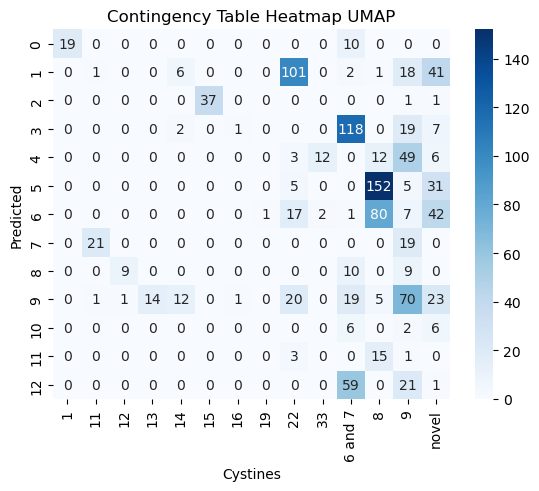

In [88]:
# Create a heatmap using Seaborn
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title('Contingency Table Heatmap UMAP')
plt.show()


In [90]:
train_df['Label_cystine_umap'] = labels

### Don't run

In [91]:
train_df.to_csv('all_toxin_pca_umap_cystine.csv', index=False)

### superfamily features

In [92]:
!git clone https://github.com/weigangq/cono-models.git

Cloning into 'cono-models'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (354/354), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 653 (delta 65), reused 320 (delta 58), pack-reused 299
Receiving objects: 100% (653/653), 14.16 MiB | 4.96 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [93]:
sup = pd.read_csv('summary.csv')

In [94]:
sup.head()

,sequence,hmm_pred,pssm_pred,definitive_pred
0,Mki1_1,A,A,A
1,Mki3_1,A,A,A
2,Hst1_1,A,A,A
3,Mki5_1,A,CONFLICT A and O1,A
4,Mki2_1,A,A,A


In [96]:
full_df = pd.read_csv('https://raw.githubusercontent.com/weigangq/cono-models/main/data/All_Toxins_v4.csv')

In [97]:
full_df.head()

,ToxinName,NewNamev2,NewNamev3,Signal,Pre,Mature,Post,Framework,Framework Confirmation,Framework Structure
0,Cje_11Cys,Cje5_Novel,Cje5_Novel,MVVLRLCVIWISVFMGMTAHT,NaN,GIKFLNCPDKPMCLEDPYQPCAVFKNDCQSPSHCECRCPGEHLREG...,GR,Novel,novel,﻿C-C-C-C-C-C-C-C-C-C-C
1,Cje_7Cys.1,Cje2_Novel,Cje2_Novel,MMLSFVVLISISVSMA,NaN,WLVPYGQLSVGIRSEEELENCQTDEVCGMVNYRNVTFCKCGNVGCP...,NaN,Novel,novel,C-C-C-C-C-C-C
2,Cje_7Cys.2,Cje3_Novel,Cje3_Novel,MMLSFVVLISISVSMA,NaN,WLVPYGQLSVGIRSEEELENCQTDEVCGMVNYRNVTFCKCGNVGCP...,NaN,Novel,novel,C-C-C-C-C-C-C
3,Cje_7Cys.3,Cje4_Novel,Cje4_Novel,MKAPAVLAIILGSFTLLHRSPGTDA,NaN,ISDDCQECKTDCERVIASCPDFKCSYGISTVLPCRLLLLAMRNIPK...,NaN,Novel,novel,C-C-C-C-C-C-C
4,Cje_9Cys.1,Cje6_Novel,Cje6_Novel,MKVPTVVVVILGLFMFLYQSPGTDA,QDPYANPDFR,NPLYPVSQECYLCYTDCQRLVGHCTNNTCPPVIACASNLCFTLMEN...,NaN,Novel,novel,C-C-C-C-C-C-C-C-C


In [98]:
merged_df = pd.merge(full_df, sup, left_on='NewNamev3', right_on='sequence', how='inner')

In [100]:
len(merged_df)

807

In [101]:
merged_df.head()

,ToxinName,NewNamev2,NewNamev3,Signal,Pre,Mature,Post,Framework,Framework Confirmation,Framework Structure,sequence,hmm_pred,pssm_pred,definitive_pred
0,Cje_7Cys.1,Cje2_Novel,Cje2_Novel,MMLSFVVLISISVSMA,NaN,WLVPYGQLSVGIRSEEELENCQTDEVCGMVNYRNVTFCKCGNVGCP...,NaN,Novel,novel,C-C-C-C-C-C-C,Cje2_Novel,UNKNOWN,CONFLICT A and M,UNKNOWN
1,Cje_7Cys.2,Cje3_Novel,Cje3_Novel,MMLSFVVLISISVSMA,NaN,WLVPYGQLSVGIRSEEELENCQTDEVCGMVNYRNVTFCKCGNVGCP...,NaN,Novel,novel,C-C-C-C-C-C-C,Cje3_Novel,UNKNOWN,A,A
2,Cje_7Cys.3,Cje4_Novel,Cje4_Novel,MKAPAVLAIILGSFTLLHRSPGTDA,NaN,ISDDCQECKTDCERVIASCPDFKCSYGISTVLPCRLLLLAMRNIPK...,NaN,Novel,novel,C-C-C-C-C-C-C,Cje4_Novel,UNKNOWN,A,A
3,Cje22.2,Cje2_22,Cje2_22,MKVLFVLAMVLVTLCLG,RRMRR,DIIEDVCNNCTVSCQWVITNEGTTLCPSGFCDEPAAFCRNLKFNMD...,K,XXII,22,C-C-C-C-C-C-C-C,Cje2_22,UNKNOWN,M,M
4,Cje22.3,Cje3_22,Cje3_22,MKLSTAFVAILGLTASLCQSSG,NaN,ADTLSMECIICKWDCEDLVTSCANNDCGPNVSTKKKCDQLVTQMEM...,G,XXII,22,C-C-C-C-C-C-C-C,Cje3_22,UNKNOWN,M,M


Use newnamev3 -> index

In [102]:
np.unique(merged_df.iloc[:,-1])

array(['A', 'CONFLICT Conkunitzin and A', 'CONFLICT Conkunitzin and L',
       'CONFLICT Conkunitzin and M', 'CONFLICT Conkunitzin and O1',
       'CONFLICT Conopressin-Conophysin and O1', 'CONFLICT D and A',
       'CONFLICT D and M', 'CONFLICT H and O1', 'CONFLICT I1 and O1',
       'CONFLICT I3 and A', 'CONFLICT I3 and O1', 'CONFLICT N and O1',
       'CONFLICT O2 and O1', 'CONFLICT P and A', 'CONFLICT P and M',
       'Conkunitzin', 'Conopressin-Conophysin', 'D', 'H', 'I1', 'I3', 'L',
       'M', 'N', 'O1', 'O2', 'O2/Contryphan', 'P', 'R', 'UNKNOWN'],
      dtype=object)

In [104]:
len(np.unique(merged_df.iloc[:,-1]))

31